# Predicting Season with MMLP
Data Set: DWD

In [1]:
import pandas as pd
import datetime
import string
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

import numpy as np
import matplotlib.pyplot as plt


## important: install the sample data that comes with Bokeh https://bokeh.pydata.org/en/0.10.0/docs/installation.html

In [2]:
#Infer target season 
#German Seasons
#SeasonID; Season Name; Month
#2; Spring; March, April, May
#3; Summer; June, July, August
#4; Autumn; September, October, November
#1; Winter; December, January, February
#spring = range(3, 5)
#summer = range(6, 8)
#fall = range(9, 11)
def season(month):
    if month not in range(1,12):
        return np.NaN
        #raise Exception('month must be integer value in interval [1...12] inclusive. The value of x was: {}'.format(month))
    return (month%12 + 3)//3

## Resample time series : Minimum Daily readings
### Limit analysis to the years 2013 - 2017

In [3]:
# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/repos/iot-htsensor/data/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')
# parse date
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))
# create index
df.set_index('datetime', inplace=True)
# extract relevant columns and rename, subset
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)
# filter period 
filter = (df.index.year >= 2013) & (df.index.year <= 2016)
df = df[filter][['D_Temp', 'D_Humi']]
# resample day
df = df[['D_Temp', 'D_Humi']].resample('D').min()
# infer season
df['season'] = df.index.to_series().apply(lambda m : season(m.month))
df.head()                                          

,D_Temp,D_Humi,season
datetime,,,
2013-01-01,3.5,68.0,1.0
2013-01-02,3.9,76.0,1.0
2013-01-03,5.0,78.0,1.0
2013-01-04,7.9,88.0,1.0
2013-01-05,6.3,94.0,1.0


## Long-Term  Temperature :  Is there a noticable pattern in temperature ? 

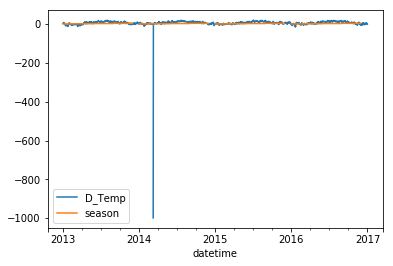

In [4]:
df[['D_Temp','season']].plot()

## Single Year Temperature : can we visually detect change in season ?

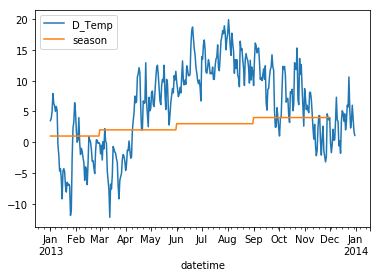

In [5]:
df[['D_Temp','season']][df.index.year == 2013].plot()

##  Long-Term Humiditiy :  Is there a noticable pattern in humidity ? 

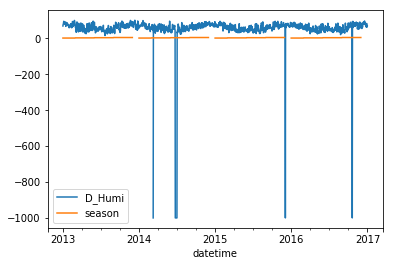

In [6]:
df[['D_Humi','season']].plot()

## Exclude negative humidity values.

In [7]:
# find and drop negative outliers 
outliers = df[df.D_Humi < 0].index
df.drop(outliers, axis=0, inplace=True)

## A seasonal humidity pattern is noticable with the removal of outliers.

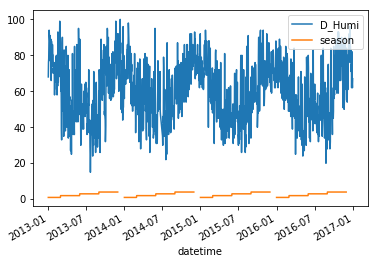

In [8]:
df[['D_Humi','season']].plot()

## Humidity Single Year:  can we visually detect change in season ?

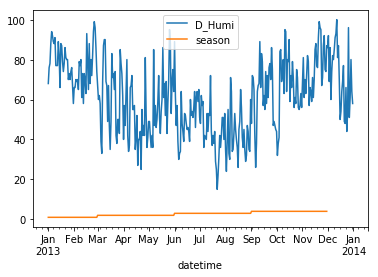

In [9]:
df[['D_Humi','season']][df.index.year == 2013].plot()

## Model Seasonality for Temperature

In [10]:
df.dropna(axis=0, inplace=True)

Coefficients: [ 1.56570044e-08 -1.35196650e-05  3.35779783e-03 -1.99298290e-01
  2.29612407e+00]


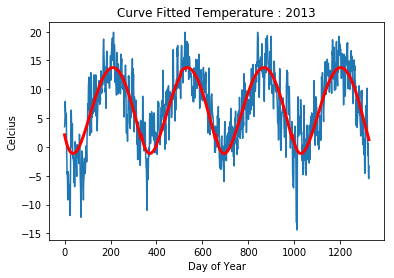

In [18]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = df.index.dayofyear
y = df['D_Temp'].values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(y)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.xlabel('Day of Year')
pyplot.ylabel('Celcius')
pyplot.title('Curve Fitted Temperature')
pyplot.show()


## Model Humidity seasonality

Coefficients: [ 1.20981837e-07  1.14993675e-03 -3.96883647e-01  8.15562000e+01]


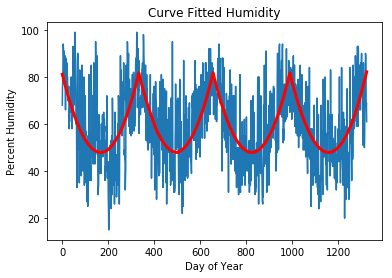

In [28]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = df.index.dayofyear
y = df['D_Humi'].values
degree =3
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(y)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.xlabel('Day of Year')
pyplot.ylabel('Percent Humidity')
pyplot.title('Curve Fitted Humidity')
pyplot.show()

## Hmm: rather pointy on top? ....

## Fit a Model with original data

In [2]:
# multivariate output mlp example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
# temp
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure

#### temp
in_seq1 = in_seq1.reshape((len(in_seq1), 1))

### humidity
in_seq2 = in_seq2.reshape((len(in_seq2), 1))

### season
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
n_output = y.shape[1]
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.58846 105.70712 206.52666]]
